## Deep Learning Term Project for ECG (DIL700)

# Imports

In [1]:
%matplotlib widget

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Custom functions
from general_functions import *

# Loading dataset

    Number of Samples: 14552
    Number of Categories: 2
    Sampling Frequency: 125Hz
    Data Source: Physionet's PTB Diagnostic Database

This dataset consists of a series of CSV files. Each of these CSV files contain a matrix, with each row representing an example in that portion of the dataset. The final element of each row denotes the class to which that example belongs. (https://www.kaggle.com/datasets/shayanfazeli/heartbeat)

In [2]:
normal_df = pd.read_csv('./Dataset_ptbdb/ptbdb_normal.csv',header=None)
abnormal_df = pd.read_csv('./Dataset_ptbdb/ptbdb_abnormal.csv',header=None)
# Combine to a full dataset
full_df = pd.concat([normal_df, abnormal_df], axis=0, ignore_index=True)

In [3]:
print('Number of samples per class: \n')
print('Normal:                 ', len(full_df[full_df[187]==0]))
print('Abnormal:               ', len(full_df[full_df[187]==1]))

Number of samples per class: 

Normal:                  4046
Abnormal:                10506


In [4]:
normal_df

0         1         2         3         4         5         6    \
0     1.000000  0.900324  0.358590  0.051459  0.046596  0.126823  0.133306   
1     1.000000  0.794681  0.375387  0.116883  0.000000  0.171923  0.283859   
2     0.909029  0.791482  0.423169  0.186712  0.000000  0.007836  0.063032   
3     1.000000  0.478893  0.056760  0.064176  0.081289  0.072732  0.055619   
4     1.000000  0.867238  0.201360  0.099349  0.141336  0.120934  0.108516   
...        ...       ...       ...       ...       ...       ...       ...   
4041  1.000000  0.929586  0.503550  0.293491  0.169822  0.159763  0.130769   
4042  1.000000  0.637579  0.154837  0.061983  0.088965  0.083374  0.065143   
4043  1.000000  0.872574  0.465071  0.232212  0.126132  0.155886  0.174644   
4044  0.915983  0.529373  0.288406  0.144536  0.171802  0.180669  0.177566   
4045  1.000000  0.838643  0.390567  0.191146  0.033513  0.055854  0.129086   

           7         8         9    ...  178  179  180  181  182  183  184  \
0     0.119125  0.110616  0.113047  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.293754  0.325912  0.345083  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.077002  0.074957  0.077342  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.048774  0.054478  0.041643  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     0.096393  0.093436  0.100828  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...        ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
4041  0.125444  0.137278  0.111243  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4042  0.057365  0.060039  0.060039  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4043  0.190168  0.203752  0.168823  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4044  0.176458  0.178896  0.180448  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4045  0.147290  0.155151  0.165494  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

      185  186  187  
0     0.0  0.0  0.0  
1     0.0  0.0  0.0  
2     0.0  0.0  0.0  
3     0.0  0.0  0.0  
4     0.0  0.0  0.0  
...   ...  ...  ...  
4041  0.0  0.0  0.0  
4042  0.0  0.0  0.0  
4043  0.0  0.0  0.0  
4044  0.0  0.0  0.0  
4045  0.0  0.0  0.0  

[4046 rows x 188 columns]

In [5]:
# Normal only contains class 0 --> healthy
normal_df[187].unique()

array([0.])

In [6]:
abnormal_df

0         1         2         3         4         5         6    \
0      0.932233  0.869679  0.886186  0.929626  0.908775  0.933970  0.801043   
1      1.000000  0.606941  0.384181  0.254237  0.223567  0.276836  0.253430   
2      1.000000  0.951613  0.923963  0.853303  0.791859  0.734255  0.672043   
3      0.977819  0.899261  0.230129  0.032348  0.142329  0.223660  0.328096   
4      0.935618  0.801661  0.805815  1.000000  0.722741  0.480789  0.454829   
...         ...       ...       ...       ...       ...       ...       ...   
10501  0.981409  1.000000  0.559171  0.287093  0.196639  0.204862  0.215946   
10502  0.906250  0.922379  0.878024  0.810484  0.712702  0.667339  0.608871   
10503  1.000000  0.867971  0.674122  0.470332  0.296987  0.169307  0.077664   
10504  1.000000  0.984672  0.658888  0.556394  0.446809  0.395790  0.315260   
10505  0.997886  0.700317  0.464059  0.318182  0.233615  0.184989  0.124207   

            7         8         9    ...  178  179  180  181  182  183  184  \
0      0.749783  0.687229  0.635100  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1      0.184826  0.153349  0.121872  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2      0.685100  0.670507  0.667435  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3      0.367837  0.381701  0.389094  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4      0.319834  0.266874  0.308411  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...         ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
10501  0.243833  0.242760  0.250268  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
10502  0.527218  0.480847  0.442540  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
10503  0.081392  0.074868  0.089779  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
10504  0.276367  0.261039  0.258522  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
10505  0.082981  0.087738  0.063953  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       185  186  187  
0      0.0  0.0  1.0  
1      0.0  0.0  1.0  
2      0.0  0.0  1.0  
3      0.0  0.0  1.0  
4      0.0  0.0  1.0  
...    ...  ...  ...  
10501  0.0  0.0  1.0  
10502  0.0  0.0  1.0  
10503  0.0  0.0  1.0  
10504  0.0  0.0  1.0  
10505  0.0  0.0  1.0  

[10506 rows x 188 columns]

In [7]:
# Abnormal only contains class 1 --> not healthy
abnormal_df[187].unique()

array([1.])

In [8]:
full_df

0         1         2         3         4         5         6    \
0      1.000000  0.900324  0.358590  0.051459  0.046596  0.126823  0.133306   
1      1.000000  0.794681  0.375387  0.116883  0.000000  0.171923  0.283859   
2      0.909029  0.791482  0.423169  0.186712  0.000000  0.007836  0.063032   
3      1.000000  0.478893  0.056760  0.064176  0.081289  0.072732  0.055619   
4      1.000000  0.867238  0.201360  0.099349  0.141336  0.120934  0.108516   
...         ...       ...       ...       ...       ...       ...       ...   
14547  0.981409  1.000000  0.559171  0.287093  0.196639  0.204862  0.215946   
14548  0.906250  0.922379  0.878024  0.810484  0.712702  0.667339  0.608871   
14549  1.000000  0.867971  0.674122  0.470332  0.296987  0.169307  0.077664   
14550  1.000000  0.984672  0.658888  0.556394  0.446809  0.395790  0.315260   
14551  0.997886  0.700317  0.464059  0.318182  0.233615  0.184989  0.124207   

            7         8         9    ...  178  179  180  181  182  183  184  \
0      0.119125  0.110616  0.113047  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1      0.293754  0.325912  0.345083  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2      0.077002  0.074957  0.077342  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3      0.048774  0.054478  0.041643  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4      0.096393  0.093436  0.100828  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...         ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
14547  0.243833  0.242760  0.250268  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
14548  0.527218  0.480847  0.442540  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
14549  0.081392  0.074868  0.089779  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
14550  0.276367  0.261039  0.258522  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
14551  0.082981  0.087738  0.063953  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       185  186  187  
0      0.0  0.0  0.0  
1      0.0  0.0  0.0  
2      0.0  0.0  0.0  
3      0.0  0.0  0.0  
4      0.0  0.0  0.0  
...    ...  ...  ...  
14547  0.0  0.0  1.0  
14548  0.0  0.0  1.0  
14549  0.0  0.0  1.0  
14550  0.0  0.0  1.0  
14551  0.0  0.0  1.0  

[14552 rows x 188 columns]

In [9]:
# Full contains both classes
full_df[187].unique()

array([0., 1.])

In [10]:
labels = ['Normal', 'Abnormal']

# Visualization

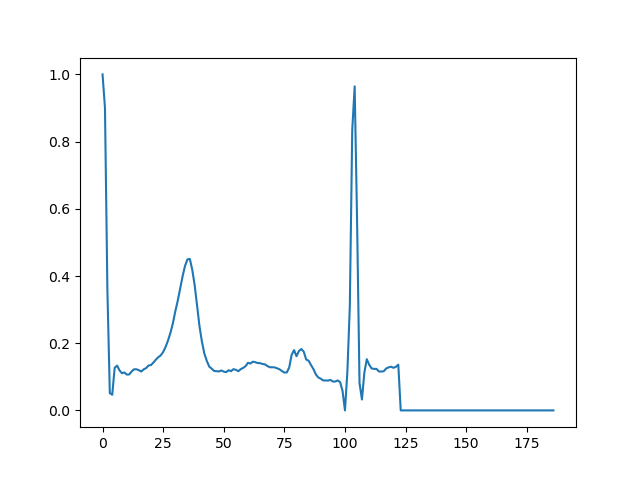

In [11]:
# Instance 0 from normal dataset
plt.figure()
ecg_example = full_df.iloc[0,:187]
plt.plot(ecg_example);

# Dataset Distribution

In [12]:
full_df[187]=full_df[187].astype(int)
equilibre=full_df[187].value_counts(sort=False)
print(equilibre)

0     4046
1    10506
Name: 187, dtype: int64


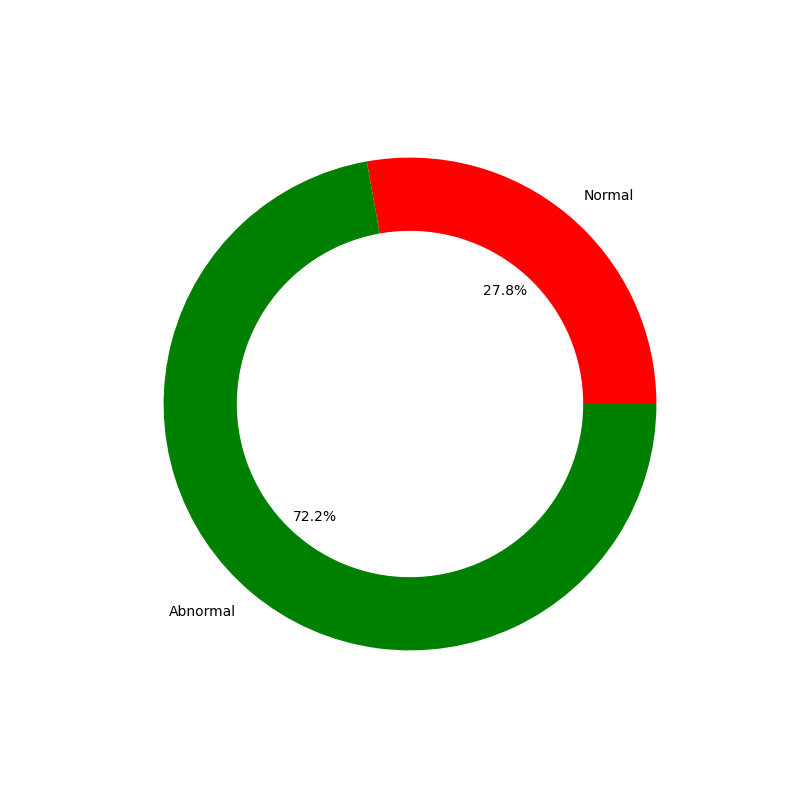

In [13]:
plt.figure(figsize=(8,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels = labels
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [14]:
samples = list()
samples.append(plot_ecg_examples(full_df, 0, 5))
samples.append(plot_ecg_examples(full_df, 1, 5))

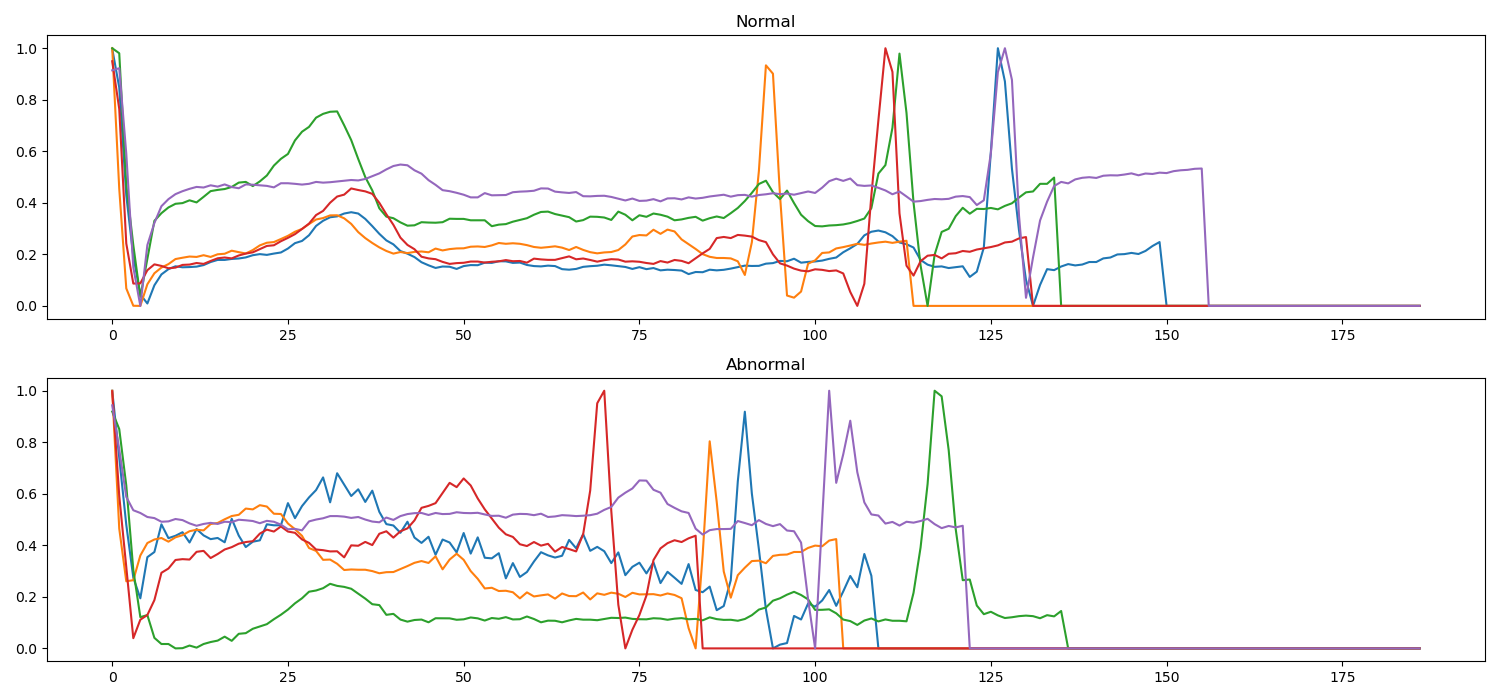

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(15, 7))
titles = ['Normal', 'Abnormal']
for i in range(len(samples)):
    ax = axs.flat[i]
    vals = samples[i].values[:,:-1].transpose()
    ax.plot(samples[i].values[:,:-1].transpose())
    ax.set_title(titles[i])

fig.tight_layout()
plt.show()

# Heatmaps of classes

# Heatmap of class 0 (Normal)

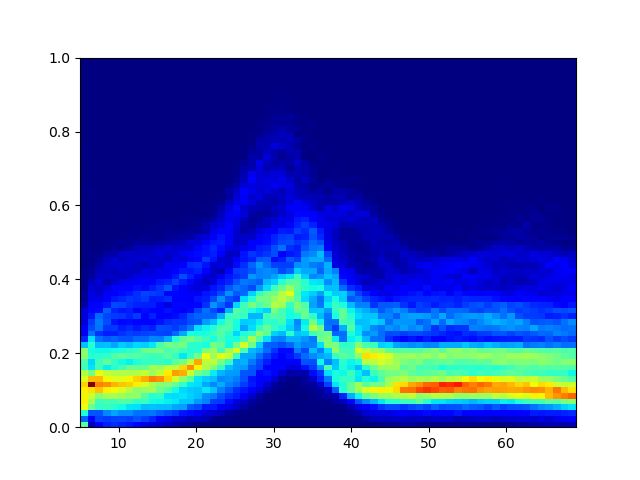

In [16]:
plt.figure()
hist_normal = plot_hist(full_df, 0, 70, 5, 65)

# Heatmap of class 1 (Abnormal)

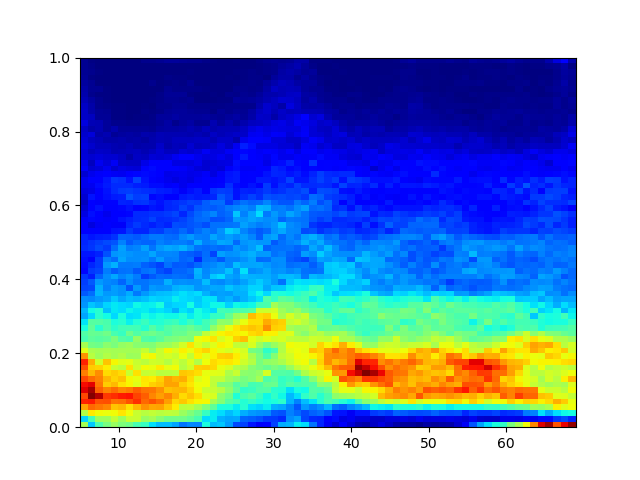

In [17]:
plt.figure()
hist_abnormal = plot_hist(full_df, 1, 70, 5, 65)

# Duration of signal per class

In [18]:
durations = list()
durations.append(mean_dur(full_df, 0))
durations.append(mean_dur(full_df, 1))

for i in range(len(durations)):
    print('Mean duration of class', labels[i], ':', durations[i])
    

Mean duration of class Normal : 130.44
Mean duration of class Abnormal : 112.65


The abnormal heart beat measurements of 1.2T are in mean value shorter than the normal heart beat measurements.

# Visualization of clusters

# kPCA

In [19]:
pca_data_0 = get_random_data_from_class(full_df, 0, n_examples=500)
pca_data_1 = get_random_data_from_class(full_df, 1, n_examples=500)

# put the different dataframes into one dataframe
pca_data = pd.concat([pca_data_0, pca_data_1])

## LinearPCA

In [20]:
# Find the first 3 principal components for both the datasets
linear_pca = KernelPCA(kernel="linear", n_components=4, random_state=0)

np_linear_pca = linear_pca.fit_transform(pca_data[pca_data.columns[:-1]])

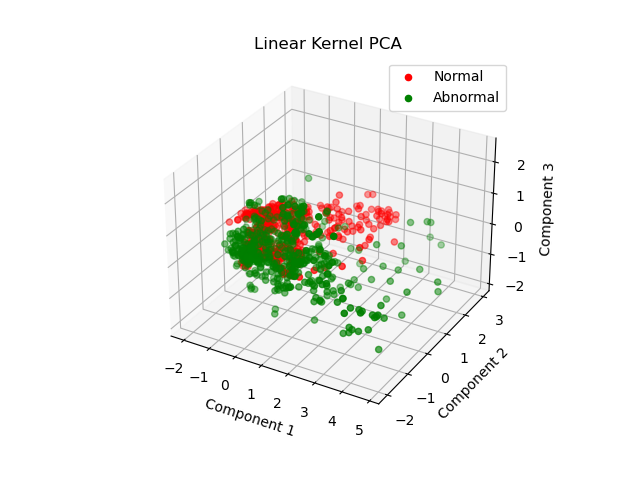

In [21]:
plot_3D_pca(np_linear_pca, pca_data, 2, labels, 'Linear Kernel PCA')

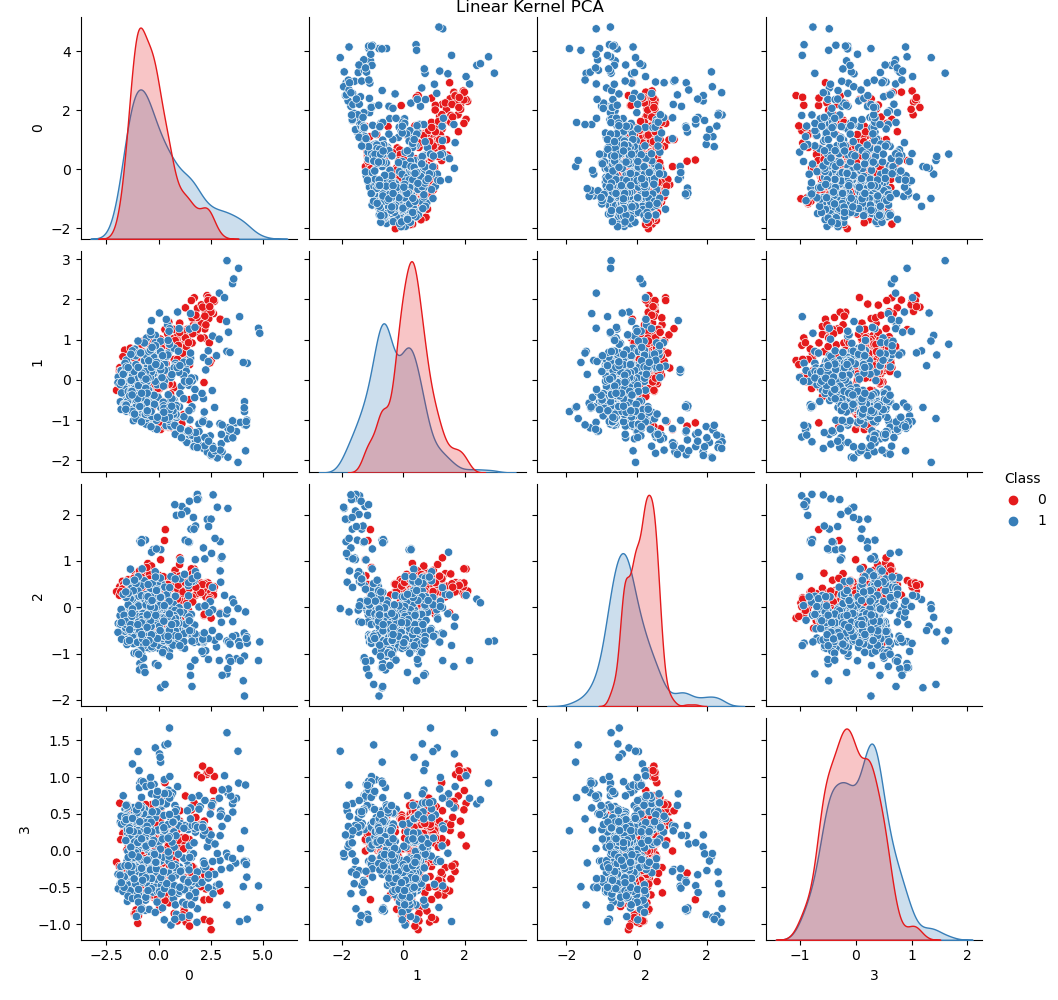

In [22]:
pairplot_pca(np_linear_pca, pca_data, 'Linear Kernel PCA')

## Sigmoid PCA

In [23]:
# Find the first 3 principal components for both the datasets
sigmoid_pca = KernelPCA(kernel="sigmoid", n_components=4, random_state=0)

np_sigmoid_pca = sigmoid_pca.fit_transform(pca_data[pca_data.columns[:-1]])

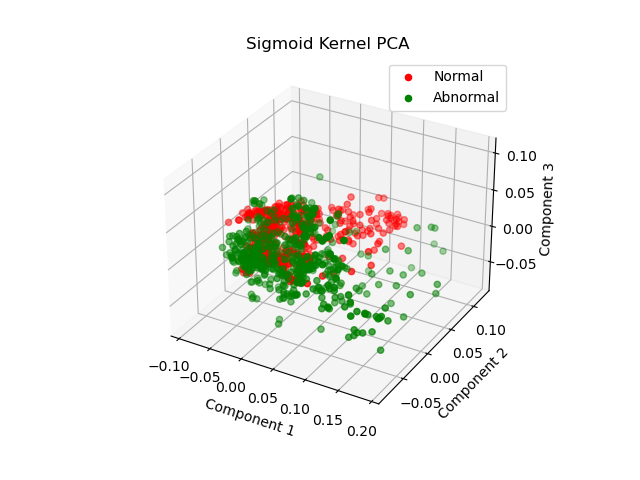

In [24]:
plot_3D_pca(np_sigmoid_pca, pca_data, 2, labels, 'Sigmoid Kernel PCA')

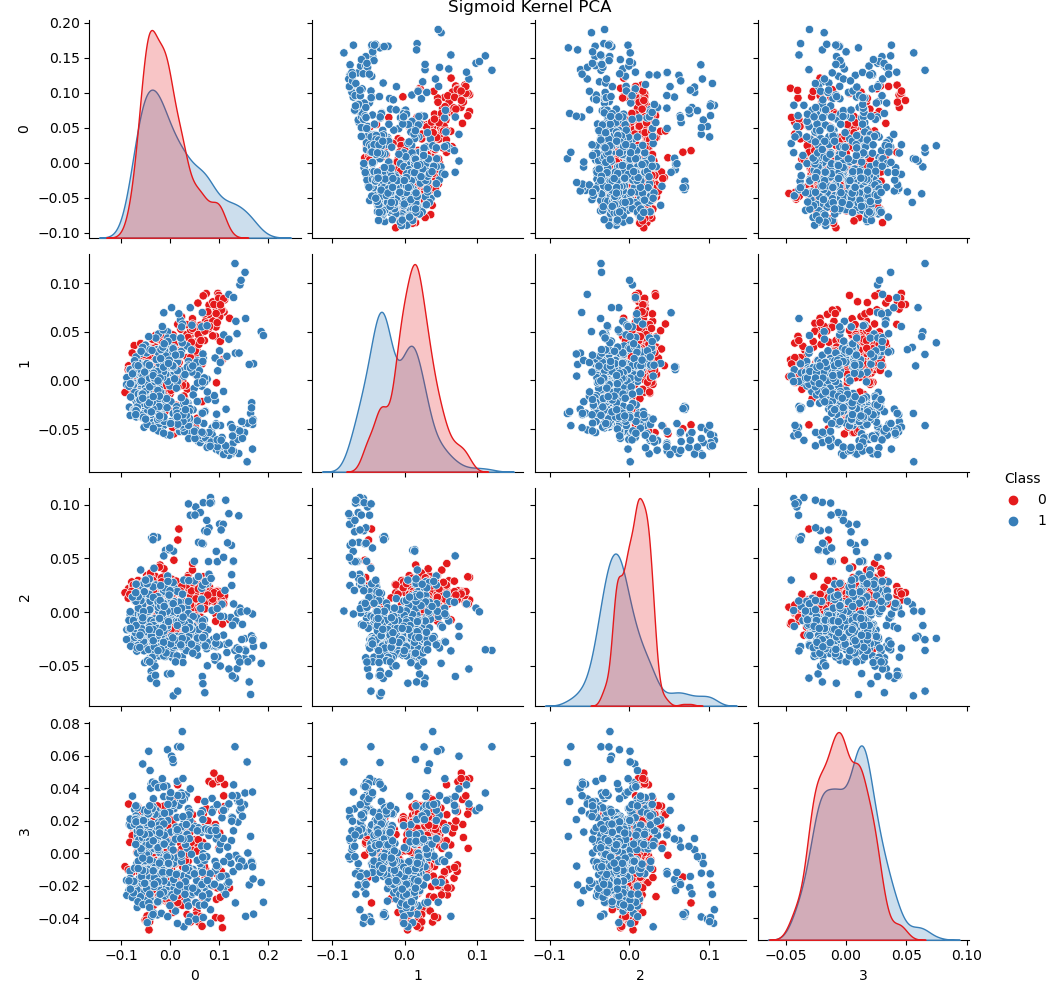

In [25]:
pairplot_pca(np_sigmoid_pca, pca_data, 'Sigmoid Kernel PCA')

## RBF PCA

In [26]:
# Find the first 3 principal components for both the datasets
rbf_pca = KernelPCA(kernel="rbf", n_components=4, random_state=0)

np_rbf_pca = rbf_pca.fit_transform(pca_data[pca_data.columns[:-1]])

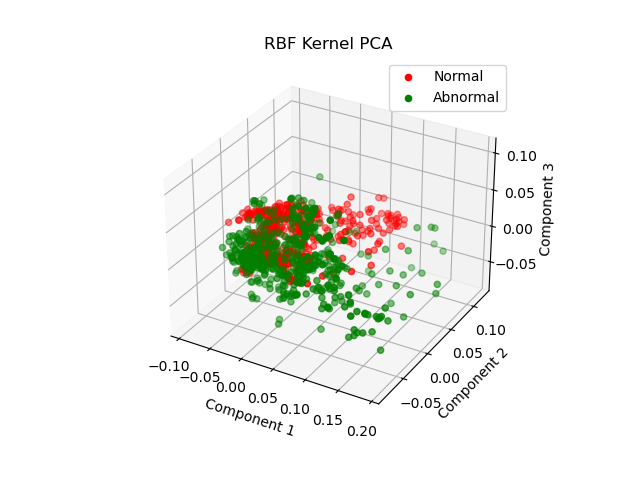

In [27]:
plot_3D_pca(np_sigmoid_pca, pca_data, 2, labels, 'RBF Kernel PCA')

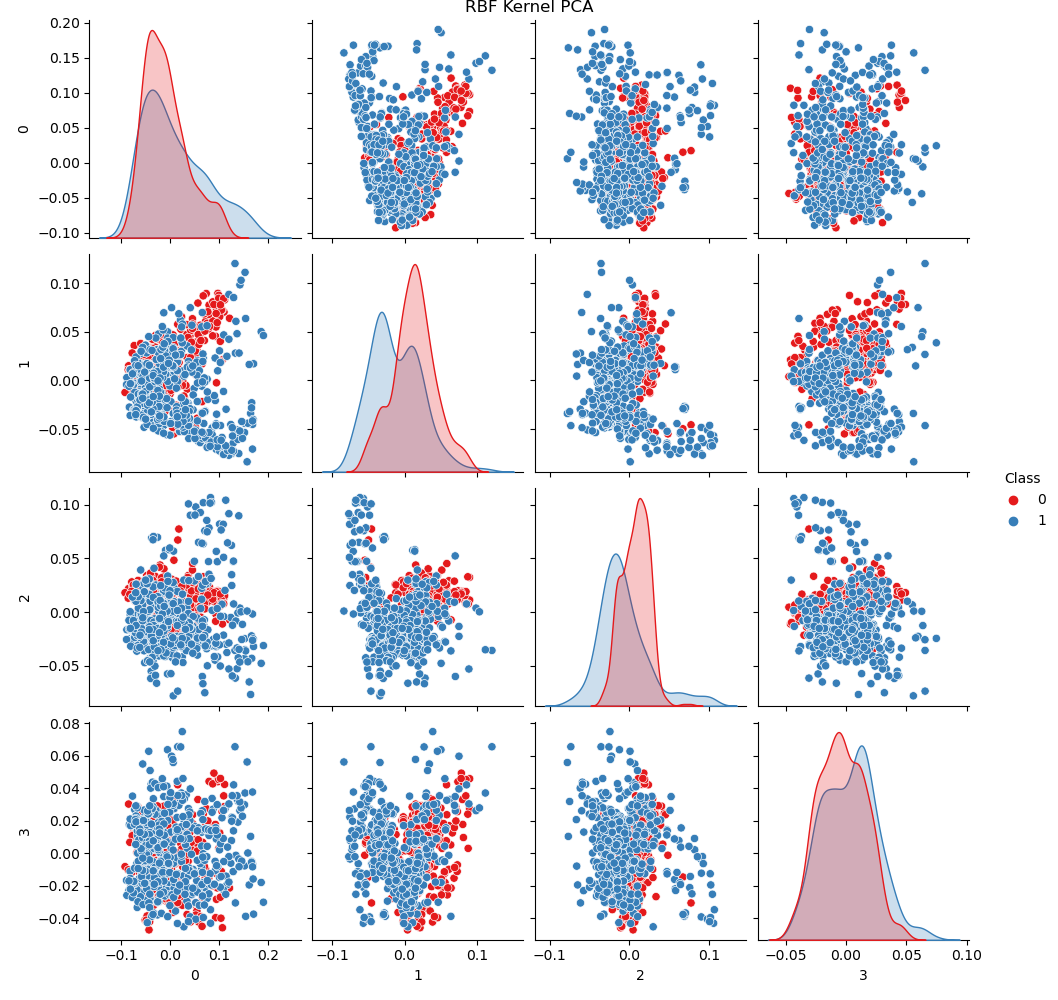

In [28]:
pairplot_pca(np_sigmoid_pca, pca_data, 'RBF Kernel PCA')

## Poly PCA

In [29]:
# Find the first 3 principal components for both the datasets
poly_pca = KernelPCA(kernel="poly", n_components=4, random_state=0, degree=3)

np_poly_pca = poly_pca.fit_transform(pca_data[pca_data.columns[:-1]])

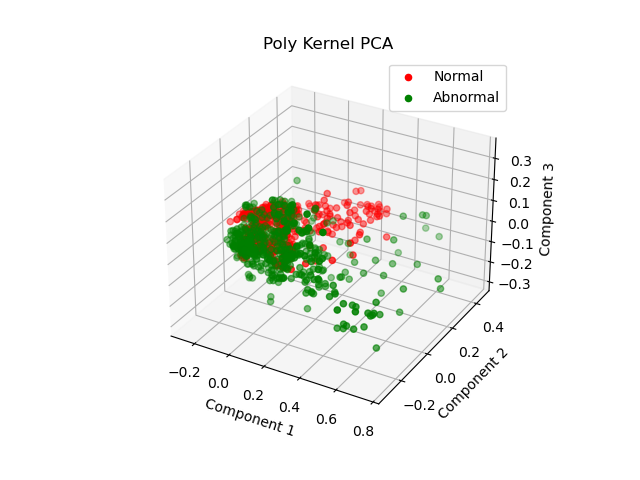

In [30]:
plot_3D_pca(np_poly_pca, pca_data, 2, labels, 'Poly Kernel PCA')

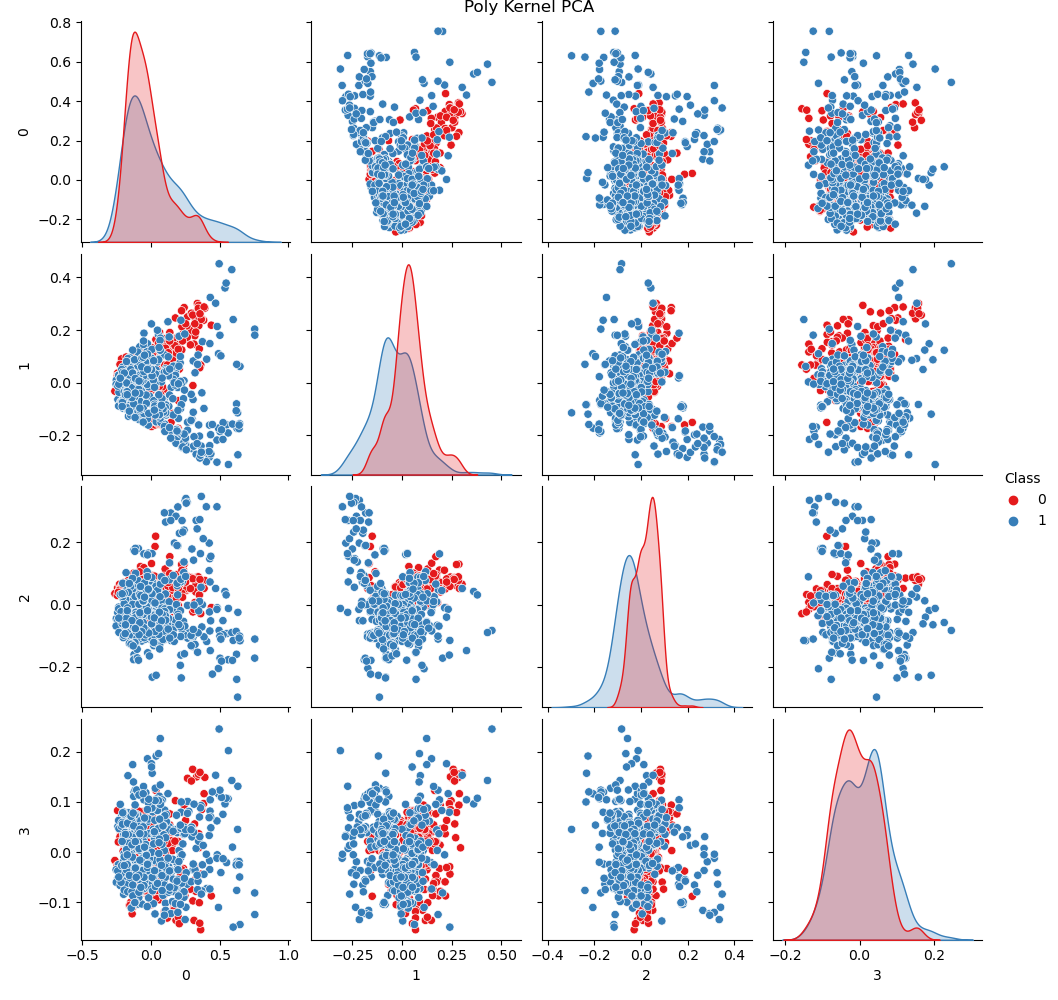

In [31]:
pairplot_pca(np_poly_pca, pca_data, 'Poly Kernel PCA')

## TSNE

Testing part for a TSNE with 3 components and 100 instances from each class

In [32]:
tsne = TSNE(n_components=4, verbose=1, random_state=123, method='exact')

# put the different dataframes into one dataframe

np_tsne = tsne.fit_transform(pca_data.values[:,:-1])

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.763002
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.897990
[t-SNE] KL divergence after 1000 iterations: 0.347514


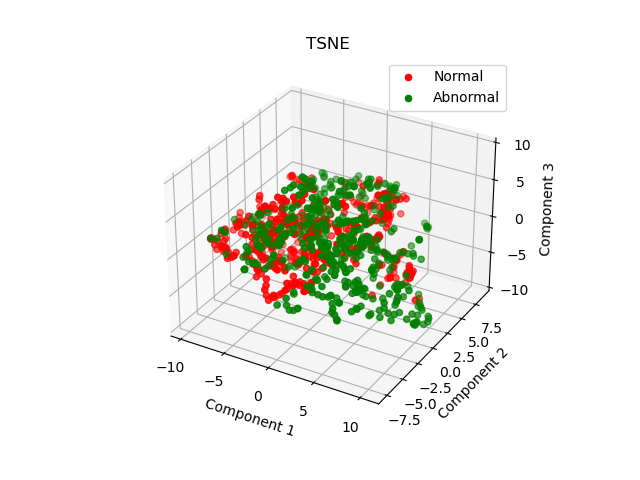

In [33]:
plot_3D_pca(np_tsne, pca_data, 2, labels, 'TSNE')

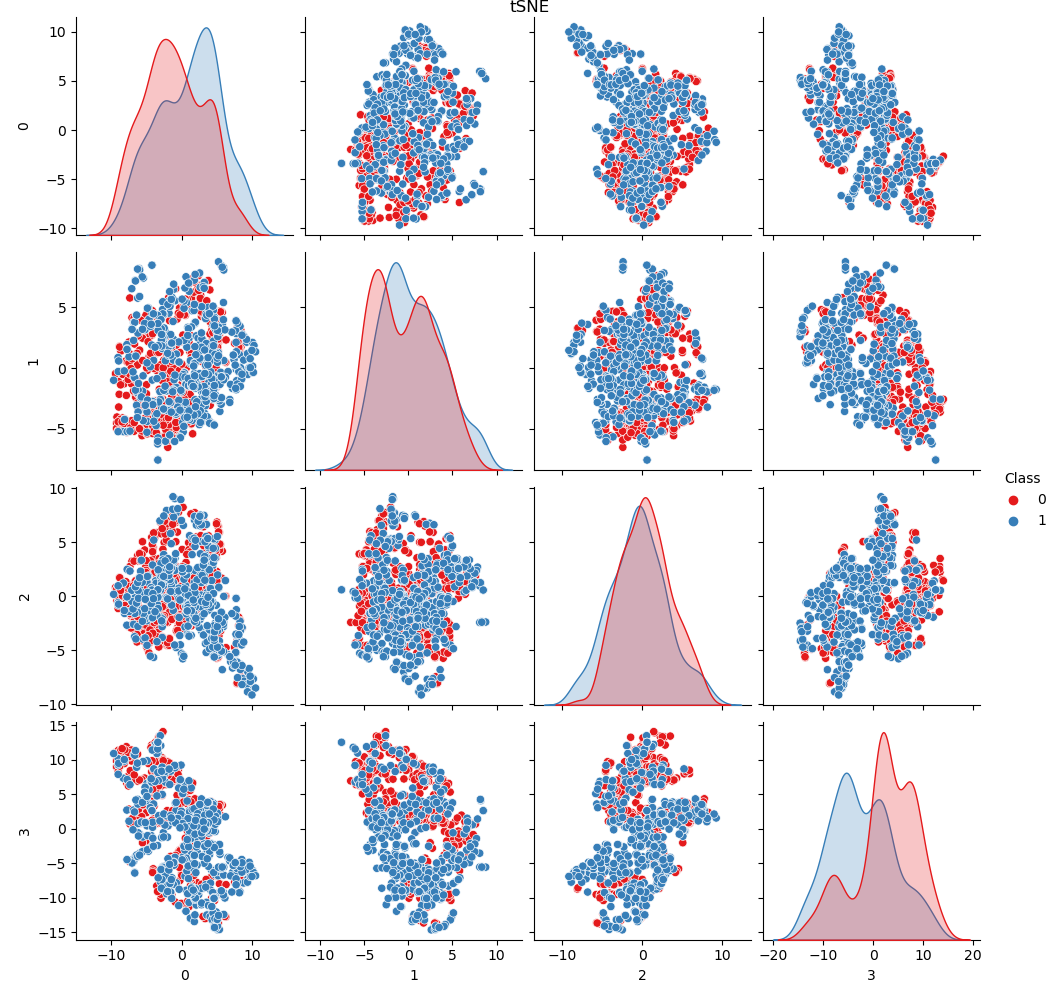

In [34]:
pairplot_pca(np_tsne, pca_data, 'tSNE')